In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','suppfig5')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1','delaydm2','contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_name_dict = {}
rule_name_dict['Go'] = rule_trains[0]
rule_name_dict['RT Go'] = rule_trains[1]
rule_name_dict['Dly Go'] = rule_trains[2]
rule_name_dict['Anti'] = rule_trains[3]
rule_name_dict['RT Anti'] = rule_trains[4]
rule_name_dict['Dly Anti'] = rule_trains[5]
rule_name_dict['Dly DM 1'] = rule_trains[6]
rule_name_dict['Dly DM 2'] = rule_trains[7]
rule_name_dict['Ctx Dly DM 1'] = rule_trains[8]
rule_name_dict['Ctx Dly DM 2'] = rule_trains[9]
rule_name_dict['MultSen Dly DM'] = rule_trains[10]
rule_name_dict['DMS'] = rule_trains[11]
rule_name_dict['DNMS'] = rule_trains[12]
rule_name_dict['DMC'] = rule_trains[13]
rule_name_dict['DNMC'] = rule_trains[14]

In [4]:
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 
            14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 
            26:'z',27:'aa',28:'bb',29:'cc',30:'dd',31:'ee',32:'ff',33:'gg',34:'hh',35:'ii',36:'jj',37:'kk',
            38:'ll',39:'mm',}

In [5]:
def plot_epoch_labels(ax, epoch_binary, which_axes = 'y', ms = .9):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')

    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        where = np.where(epoch_binary[e_name])[0]-.7
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)

            for w in where:
            
                rect = patches.Rectangle((w, yl), 1, 3,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)
            
            for w in where:
                rect = patches.Rectangle((xl, w), 3, 1,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
            
def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())+2
        xl = np.max(ax.get_xlim())+2

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
        

In [6]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

feature_names_master = cluster_var['tick_names']


Choosing 37 clusters


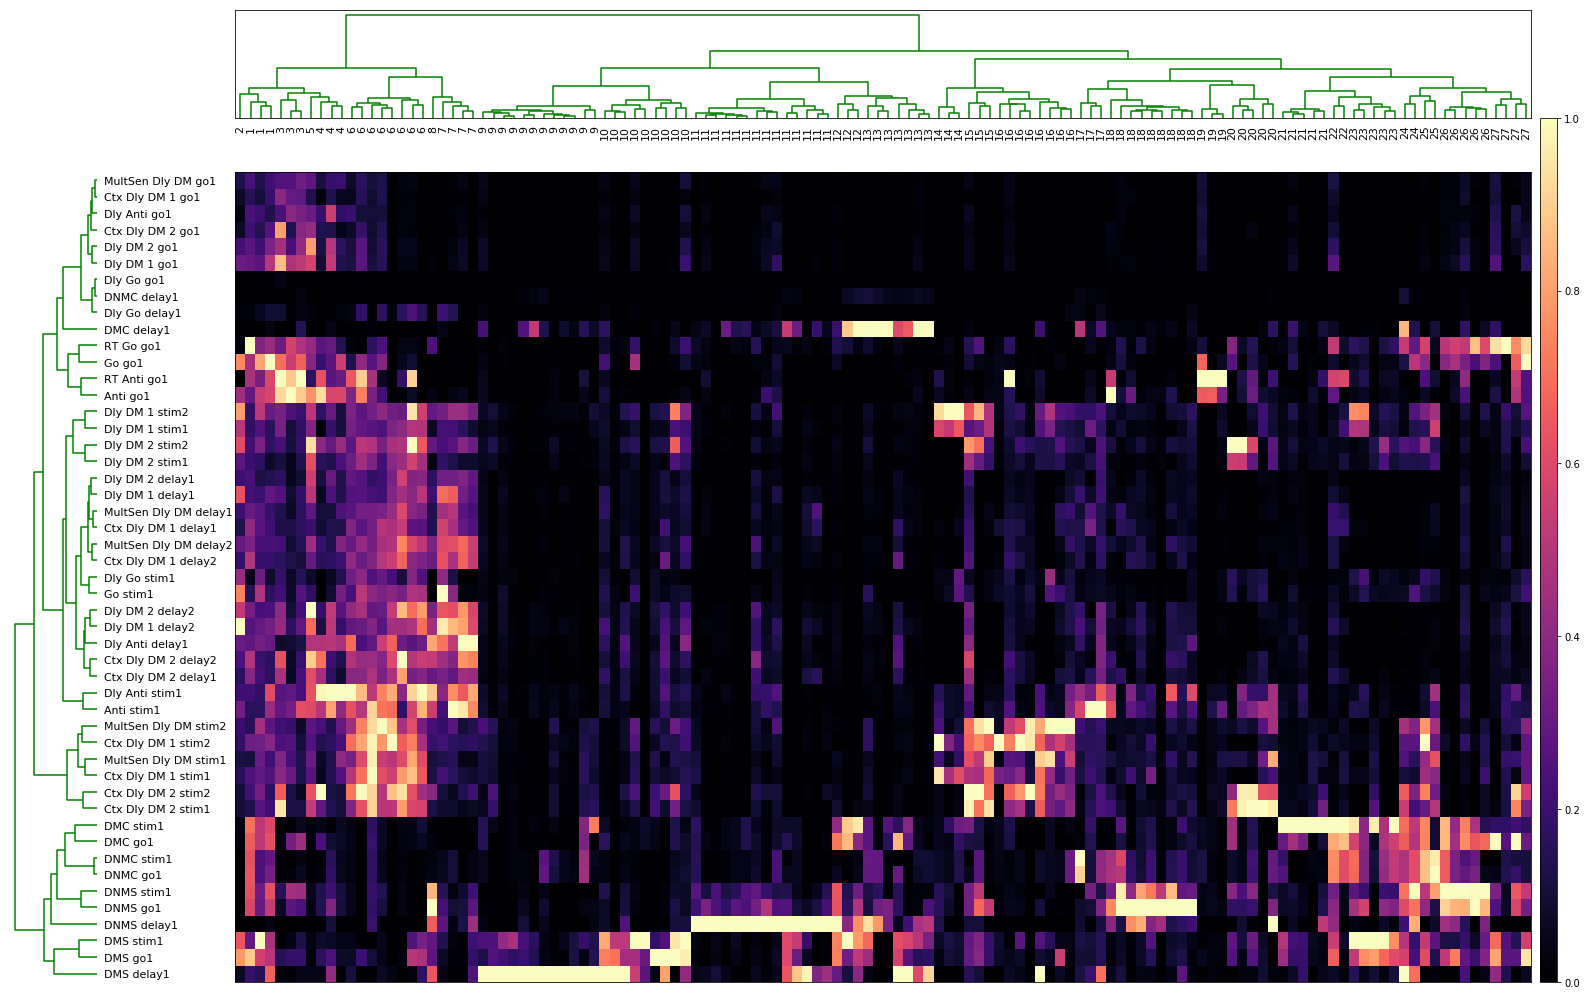

In [7]:
from tools_lnd import make_dendro
make_dendro(m,method = 'ward',criterion = 'maxclust',cel_max_d = 0,max_d = 0,normalization_method = 'max')

In [16]:
# import numpy.linalg as LA

n_unit = len(cluster_var['index_top'])

# cluster_ones = np.zeros((len(cluster_var['lesion_units_list']),n_unit))
# for x in range(1,len(cluster_var['lesion_units_list'])):
#     cluster_ones[x,cluster_var['lesion_units_list'][x]] = 1
#     cluster_ones[[x],:] = cluster_ones[[x],:]/LA.norm(cluster_ones[[x],:])
    
# all_ones = np.ones((1,n_unit))
# all_ones = all_ones/LA.norm(all_ones)

In [20]:
from tools_lnd import make_h_all
h_all_byepoch, h_all_byrule, _, _, y_loc_byepoch, y_loc_byrule = make_h_all(m,mode = 'test')

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [21]:
# epoch = 'stim1'
# rule = 'dmcgo'
# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,0)
# f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',rule,filename+'.npz')
# fp_struct = np.load(f)
# fp_use = np.where(fp_struct['qstar']<q_thresh)[0] 

In [22]:
from tools_lnd import same_mov_inds, get_interp_filename, take_names, find_closest_fp_loc, get_filename
from tools_lnd import gen_trials_from_model_dir, make_D_use, interp3d, get_model_params
from task import rules_dict

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1','delaydm2','contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

len_t_set = 32
q_thresh = 1e-2
sorted_fps_dict =  {}
var_fp_in_clust = {}
fp_atlas = np.zeros((len(feature_names_master),n_unit)) #len(cluster_var['lesion_units_list'])))
y_locs = np.zeros((len(feature_names_master),len_t_set))  

for task_per_ind in range(len(feature_names_master)):

    epoch = feature_names_master[task_per_ind].rsplit(' ', 1)[-1]
    rule = rule_name_dict[feature_names_master[task_per_ind].rsplit(' ', 1)[0]]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    n_steps, n_trials, n_input_dim = np.shape(trial.x[:,inds_use,:])

    cat_sorted_fps = []
    tset1 = range(3,n_trials,int(n_trials/16))[:int(len_t_set/2)]
    tset2 = range(0,n_trials,int(n_trials/16))[:int(len_t_set/2)]
    t_set = np.sort(np.concatenate((tset1,tset2)))
    
    for ti in t_set:#trial number

        if any(trial.x[trial.epochs[epoch][0]+1,0,:] - trial.x[trial.epochs[epoch][0]+1,1,:])!=0 :
            filename,_ = get_filename(trial,epoch,inds_use[ti])
        else: 
            filename,_ = get_filename(trial,epoch,inds_use[0])

        f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',rule,filename+'.npz')
        fp_struct = np.load(f)
        fp_use = np.where(fp_struct['qstar']<q_thresh)[0] 

        h_end = h_all_byepoch[(rule,epoch)][-1,ti,:]
        _, closest_fp_loc = find_closest_fp_loc(h_end,fp_struct['xstar'][fp_use,:])

        if len(cat_sorted_fps)==0:
            cat_sorted_fps = closest_fp_loc[np.newaxis,:]
        else:
            cat_sorted_fps = np.concatenate((cat_sorted_fps, closest_fp_loc[np.newaxis,:]))

    sorted_fps_dict[rule,epoch] = cat_sorted_fps
    var_fp_in_clust[rule,epoch] = np.zeros((n_unit))#len(cluster_var['lesion_units_list'])))    
    
    for x in range(n_unit):#len(cluster_var['lesion_units_list'])):
        
#         u = cluster_ones[[x,],:]
        u = np.zeros((1,n_unit))
        u.flat[x] = 1

        AuT = np.dot(sorted_fps_dict[rule,epoch],u.T)
        uA = np.dot(u,sorted_fps_dict[rule,epoch].T) 
        trace_ATA = np.trace(np.dot(sorted_fps_dict[rule,epoch],sorted_fps_dict[rule,epoch].T))
        uAAu_trace_ATA = np.dot(uA,AuT)/trace_ATA

        var_fp_in_clust[rule,epoch][x] = uAAu_trace_ATA

    fp_atlas[task_per_ind,:] = var_fp_in_clust[rule,epoch]/np.max(var_fp_in_clust[rule,epoch])
    y_locs[task_per_ind,:] = trial.y_loc[-1,t_set]


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

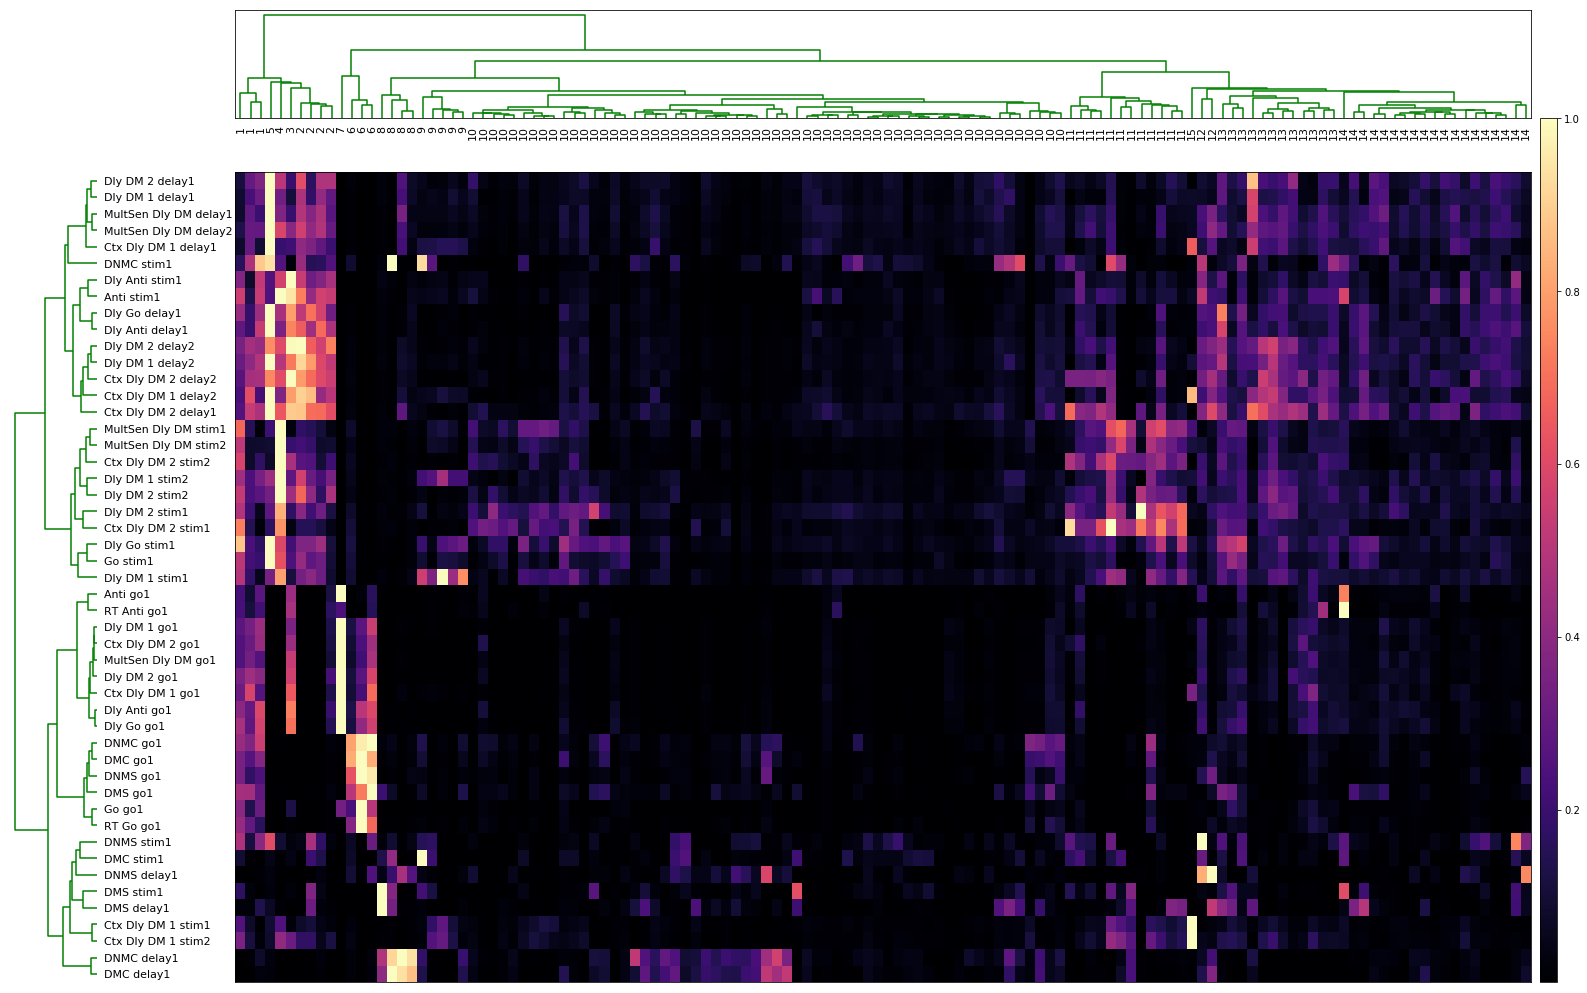

In [23]:
from analysis import clustering, standard_analysis, variance
from task import generate_trials, rule_name, rules_dict
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from tools_lnd import find_opt_clust_num

method = 'ward'
criterion = 'distance'
cel_max_d = 0
max_d = 0
normalization_method='sum'#max'

# CA = clustering.Analysis(m, data_type='epoch', normalization_method=normalization_method)
tick_names = cluster_var['tick_names']

# Generate features and distance matrix.
D  = fp_atlas#cluster_var['D'][:, :]

# Compute and plot dendrogram.
fig = plt.figure(figsize=(24, 15))
axdendro = fig.add_axes([0.09,0.1,0.05,0.75])

Y = sch.linkage(D, method=method)

if max_d==0:
    max_d = find_opt_clust_num(D,Y)
    clusters = fcluster(Y, max_d, criterion='maxclust')
else:
    clusters = fcluster(Y, max_d, criterion=criterion)
Z = sch.dendrogram(Y, orientation='left',labels = tick_names,
                   leaf_font_size = 11,color_threshold=max_d)

axdendro.set_xticks([])
axdendro.spines['top'].set_visible(False)
axdendro.spines['right'].set_visible(False)
axdendro.spines['bottom'].set_visible(False)
axdendro.spines['left'].set_visible(False)

# Plot distance matrix.
axmatrix = fig.add_axes([0.22,0.1,0.75,0.75])
index_left = Z['leaves']
tick_names_sorted = [tick_names[i] for i in index_left]
D = D[index_left,:]

# cel_num = [CA.ind_active[x] for x in index_top]
axdendro_top = fig.add_axes([0.22,.9,0.75,0.1])

Y = sch.linkage(D.T, method=method)
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_opt_clust'
cel_max_d = 15#find_opt_clust_num(D.T,Y)

clusters = fcluster(Y, cel_max_d, criterion='maxclust')

Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
               leaf_font_size = 11,color_threshold=cel_max_d)

axdendro_top.set_yticks([])

index_top = Z['leaves']
D = D[:,index_top]
clusters_sorted = clusters[index_top]
im = axmatrix.matshow(D, aspect='auto', origin='lower',cmap='magma')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.975,0.1,0.01,0.8])
plt.colorbar(im, cax=axcolor)

In [24]:
import numpy.linalg as LA
from sklearn.decomposition import PCA


m_master = m
n_unit = np.shape(h_all_byepoch['delaygo','stim1'])[2]
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

cluster_ones = np.zeros((len(cluster_var['lesion_units_list']),n_unit))
for x in range(1,len(cluster_var['lesion_units_list'])):
    cluster_ones[x,cluster_var['lesion_units_list'][x]] = 1
    cluster_ones[[x],:] = cluster_ones[[x],:]/LA.norm(cluster_ones[[x],:])
    
all_ones = np.ones((1,n_unit))
all_ones = all_ones/LA.norm(all_ones)

In [25]:
from tools_lnd import remove_spines, remove_ticks, task_name_dict, rule_set_names, take_names

def plot_var_in_cluster(feature_names_master,lesion_units_list,X_by_epoch,cluster_ones,y_locs,
                        task_name_dict = task_name_dict,rule_name_dict = rule_name_dict, sort = 'F',
                        viz_start = 1,viz_end = []):
    
    if not viz_end<len(feature_names_master):
        viz_end = len(feature_names_master)
    len_subplots = viz_end - viz_start
    fname = str(viz_start)+'_'+str(viz_end)
        
    nc = 6
    fp_var_mat = np.zeros((len(feature_names_master),len(lesion_units_list)))
    fig = plt.figure(figsize=(2*nc+1,2*len_subplots),tight_layout=True,facecolor='white')
    sp_ind_master = 0
    lim_diff = .1
    

    for task_per_ind in range(viz_start,viz_end):
        
#         fig = plt.figure(figsize=(12,2*len_subplots),tight_layout=True,facecolor='white')

        epoch = feature_names_master[task_per_ind].rsplit(' ', 1)[-1]
        rule = rule_name_dict[feature_names_master[task_per_ind].rsplit(' ', 1)[0]]
        
        if len(np.shape(X_by_epoch[(rule,epoch)]))>2:
            
            ####### C(time) or F(stimulus)
            
                ###Plot full trial
            X = np.reshape(X_by_epoch[(rule,epoch)],(-1,np.shape(X_by_epoch[(rule,epoch)])[2]),order = sort) 
            y_locs_curated = np.reshape(y_locs[(rule,epoch)],(-1),order = sort) 
            al = 150/len(X)

                ###Trial subset (same as FPs)
#             trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#             inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
#             n_steps, n_trials, n_input_dim = np.shape(trial.x[:,inds_use,:])

#             tset1 = range(3,n_trials,int(n_trials/16))[:int(len_t_set/2)]
#             tset2 = range(0,n_trials,int(n_trials/16))[:int(len_t_set/2)]
#             t_set = np.sort(np.concatenate((tset1,tset2)))

                ###ALL trials
            t_set = range(n_trials)
    
                ##Only plot trial end
#             X = X_by_epoch[(rule,epoch)][-1,t_set,:]
#             y_locs_curated = y_locs[(rule,epoch)][-1,t_set]
#             al = 15/len(X)
            
            figname = 'h_vis'
            
            
        else:
            X = X_by_epoch[rule,epoch]
            y_locs_curated = y_locs[task_per_ind,:]
            al = 15/len(X)
            
            figname = 'fp_vis'
        
        pca = PCA(n_components = 2)
        _ = pca.fit_transform(X)
        projection_dims = pca.components_

        ax_main = plt.subplot(len_subplots,nc,(sp_ind_master)*nc+1)

        fp_project = np.dot(X,projection_dims.T)
        ax_main.scatter(fp_project[:,0],fp_project[:,1],
                   s = 10*1.5,
                   marker = 'o',
                   c = y_locs_curated,
                   alpha = al,
                   linewidth = 5,
                  cmap = 'hsv')

        remove_spines(ax_main)
        remove_ticks(ax_main)
        plt.axis('equal')
        x_diff = ax_main.get_xlim()[1]-ax_main.get_xlim()[0]
        y_diff = ax_main.get_ylim()[1]-ax_main.get_ylim()[0]
        xlims = [ax_main.get_xlim()[0]-lim_diff*x_diff, ax_main.get_xlim()[1]+lim_diff*x_diff]
        ylims = [ax_main.get_ylim()[0]-lim_diff*y_diff, ax_main.get_ylim()[1]+lim_diff*y_diff]
        ax_main.set_xlim(xlims)
        ax_main.set_ylim(ylims)

        epoch_name, rule_name, _, _ = take_names(epoch,rule)
        plt.title(rule_name+'\n'+epoch_name,fontsize = 16)

        for x in range(1,len(lesion_units_list)):
            
            AuT = np.dot(X,cluster_ones[[x,],:].T)
            uA = np.dot(cluster_ones[[x,],:],X.T) 
            trace_ATA = np.trace(np.dot(X,X.T))
            uAAu_trace_ATA = np.dot(uA,AuT)#/trace_ATA

            fp_var_mat[task_per_ind,x] = uAAu_trace_ATA # np.var(np.dot(X,cluster_ones[[x,],:].T)) # 

        max_clust = np.argsort(-fp_var_mat[task_per_ind,:])

        sp_ind = 2
        for mc in max_clust[:nc-1]:

            ax = plt.subplot(len_subplots,nc,(sp_ind_master)*nc+sp_ind)
            X_alt = X[:,cluster_ones[mc,:]>0]

            if np.sum(cluster_ones[mc,:])>1:
                pca_alt = PCA(n_components = 2)
                _ = pca_alt.fit_transform(X_alt)
                projection_dims_alt = pca_alt.components_

                fp_project = np.dot(X_alt,projection_dims_alt.T)
                ax.scatter(fp_project[:,0],fp_project[:,1],
                           s = 10*1.5,
                           marker = 'o',
                           c = y_locs_curated,
                           alpha = al,
                           linewidth = 5,
                           cmap = 'hsv')
            else:

                ax.scatter(X_alt[:,0],np.zeros(np.shape(X_alt[:,0])),
                           s = 10*1.5,
                           marker = 'o',
                           c = y_locs_curated,
                           alpha = al,
                           linewidth = 5,
                           cmap = 'hsv')

            norm_var = fp_var_mat[task_per_ind,mc]/np.sum(fp_var_mat[task_per_ind,:])
            plt.title(r"$\bf{" + alphabet[mc] + "}$"+" {:.3f}".format(norm_var),fontsize = 20,y = 1.2) #
            
#             center_x = np.mean((ax.get_xlim()[0],ax.get_xlim()[1]))
#             center_y = np.mean((ax.get_ylim()[0],ax.get_ylim()[1]))
#             frac_diff = .5+lim_diff
#             xlims = [center_x-frac_diff*x_diff, center_x+frac_diff*x_diff]
#             ylims = [center_y-frac_diff*y_diff, center_y+frac_diff*y_diff]
            
#             ax.set_xlim(xlims)
#             ax.set_ylim(ylims)

            plt.axis('equal')
            x_diff = ax.get_xlim()[1]-ax.get_xlim()[0]
            y_diff = ax.get_ylim()[1]-ax.get_ylim()[0]
            xlims = [ax.get_xlim()[0]-lim_diff*x_diff, ax.get_xlim()[1]+lim_diff*x_diff]
            ylims = [ax.get_ylim()[0]-lim_diff*y_diff, ax.get_ylim()[1]+lim_diff*y_diff]
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)

            remove_spines(ax)
            remove_ticks(ax)
            fig.tight_layout()
            
            sp_ind += 1
            
        sp_ind_master += 1
     
    plt.savefig(os.path.join(figpath,figname+fname+'.pdf'))
    return fp_var_mat
    

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


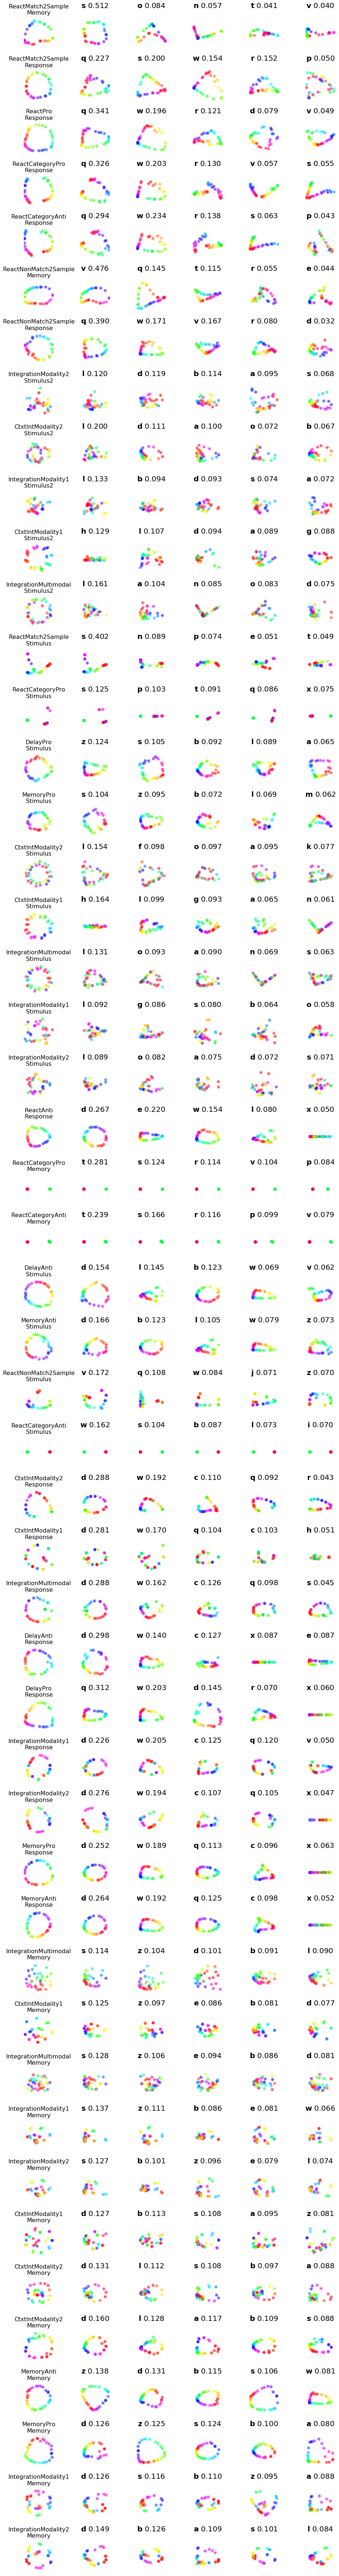

In [26]:
lesion_units_list = cluster_var['lesion_units_list']
X_by_epoch = sorted_fps_dict
F_fp = plot_var_in_cluster(feature_names_master,lesion_units_list,X_by_epoch,cluster_ones,y_locs,
                        task_name_dict = task_name_dict,sort = 'F',viz_start = 0, viz_end = 49)